In [35]:
import pandas as pd

In [36]:
orders = pd.read_csv("/content/orders.csv")
order_products = pd.read_csv("/content/order_products__prior.csv")
products = pd.read_csv("/content/products.csv")


In [37]:
orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [38]:
print(orders.shape)
print(order_products.shape)
print(products.shape)


(3421083, 7)
(32434489, 4)
(49688, 4)


In [39]:
merged = order_products.merge(products, on="product_id")

In [40]:
merged.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [41]:
top_products = (
    merged["product_name"]
    .value_counts()\
    .head(10)
)
top_products

,count
product_name,
Banana,472565
Bag of Organic Bananas,379450
Organic Strawberries,264683
Organic Baby Spinach,241921
Organic Hass Avocado,213584
Organic Avocado,176815
Large Lemon,152657
Strawberries,142951
Limes,140627


In [42]:
import matplotlib.pyplot as plt

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Banana'),
  Text(1, 0, 'Bag of Organic Bananas'),
  Text(2, 0, 'Organic Strawberries'),
  Text(3, 0, 'Organic Baby Spinach'),
  Text(4, 0, 'Organic Hass Avocado'),
  Text(5, 0, 'Organic Avocado'),
  Text(6, 0, 'Large Lemon'),
  Text(7, 0, 'Strawberries'),
  Text(8, 0, 'Limes'),
  Text(9, 0, 'Organic Whole Milk')])

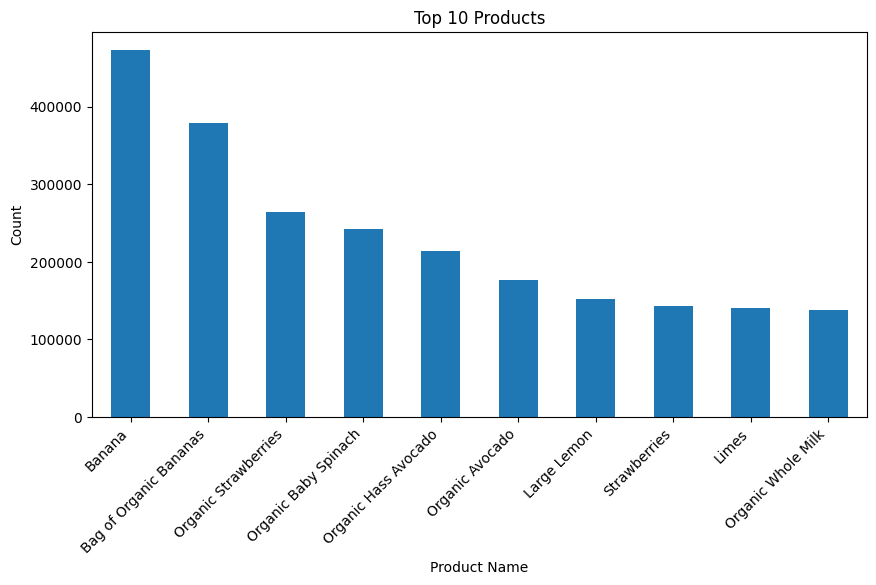

In [43]:
plt.figure(figsize=(10, 5))
top_products.plot(kind="bar")
plt.title("Top 10 Products")
plt.xlabel("Product Name")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")


In [44]:
test_user = 1

In [45]:
merged_user = merged.merge(
    orders[["order_id", "user_id"]],
    on="order_id"
)


In [46]:
merged_user.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id
0,2,33120,1,1,Organic Egg Whites,86,16,202279
1,2,28985,2,1,Michigan Organic Kale,83,4,202279
2,2,9327,3,0,Garlic Powder,104,13,202279
3,2,45918,4,1,Coconut Butter,19,13,202279
4,2,30035,5,0,Natural Sweetener,17,13,202279


In [47]:
print(merged_user.shape)
merged_user.head()


(32434489, 8)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id
0,2,33120,1,1,Organic Egg Whites,86,16,202279
1,2,28985,2,1,Michigan Organic Kale,83,4,202279
2,2,9327,3,0,Garlic Powder,104,13,202279
3,2,45918,4,1,Coconut Butter,19,13,202279
4,2,30035,5,0,Natural Sweetener,17,13,202279


In [48]:
cart_products = (
    merged
    .groupby("order_id")["product_name"]
    .apply(list)
)


In [49]:
def hybrid_recommender(
    user_id,
    merged_user,
    cart_products,
    top_products,
    top_n=5
):
    # Products user already bought
    user_products = set(
        merged_user[merged_user["user_id"] == user_id]["product_name"]
    )

    recommendations = []

    # 1️⃣ Similar users
    similar_users = merged_user[
        merged_user["product_name"].isin(user_products)
    ]["user_id"].unique()

    similar_users = [u for u in similar_users if u != user_id]

    similar_products = (
        merged_user[merged_user["user_id"].isin(similar_users)]
        ["product_name"]
        .value_counts()
    )

    for product in similar_products.index:
        if product not in user_products:
            recommendations.append(product)
        if len(recommendations) >= top_n:
            return recommendations

    # 2️⃣ Bought together
    for product in user_products:
        if product in cart_products.values:
            related = recommend_frequently_bought(
                product, cart_products, top_n
            )
            for item, _ in related:
                if item not in user_products and item not in recommendations:
                    recommendations.append(item)
                if len(recommendations) >= top_n:
                    return recommendations

    # 3️⃣ Popular fallback
    for product in top_products.index:
        if product not in user_products:
            recommendations.append(product)
        if len(recommendations) >= top_n:
            break

    return recommendations


In [50]:
hybrid_recommender(
    user_id=1,
    merged_user=merged_user,
    cart_products=cart_products,
    top_products=top_products,
    top_n=5
)


['Banana',
 'Organic Strawberries',
 'Organic Baby Spinach',
 'Organic Hass Avocado',
 'Organic Avocado']

In [51]:
hybrid_recommender(
    user_id=1,
    merged_user=merged_user,
    cart_products=cart_products,
    top_products=top_products,
    top_n=5
)


['Banana',
 'Organic Strawberries',
 'Organic Baby Spinach',
 'Organic Hass Avocado',
 'Organic Avocado']

In [52]:

test_user = merged_user["user_id"].value_counts().index[0]

def get_last_order_products(user_id, merged_user):
    user_data = merged_user[merged_user["user_id"] == user_id]

    if user_data.empty:
        return set()

    last_order_id = user_data["order_id"].iloc[-1]

    return set(
        user_data[user_data["order_id"] == last_order_id]["product_name"]
    )

recommended = hybrid_recommender(
    user_id=test_user,
    merged_user=merged_user,
    cart_products=cart_products,
    top_products=top_products,
    top_n=5
)


actual = get_last_order_products(test_user, merged_user)

hit = any(item in recommended for item in actual)

print("Test User:", test_user)
print("Recommended Products:", recommended)
print("Actual Last Order Products:", actual)
print("Hit:", hit)


Test User: 201268
Recommended Products: ['Organic Avocado', 'Organic Whole Milk', 'Organic Yellow Onion', 'Organic Garlic', 'Organic Zucchini']
Actual Last Order Products: {'Vanilla Bean Tea Bags', 'Roasted & Salted Almonds', 'Organic Large Brown Grade AA Cage Free Eggs'}
Hit: False


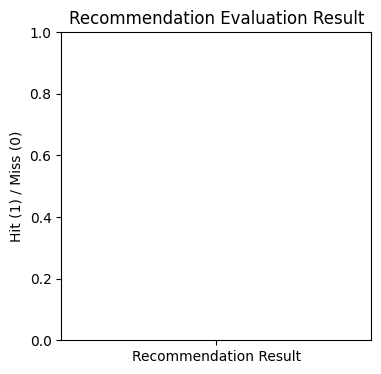

In [53]:
import matplotlib.pyplot as plt

# Convert hit to numeric
hit_value = 1 if hit else 0

plt.figure(figsize=(4, 4))
plt.bar(["Recommendation Result"], [hit_value])
plt.ylim(0, 1)
plt.ylabel("Hit (1) / Miss (0)")
plt.title("Recommendation Evaluation Result")

plt.show()


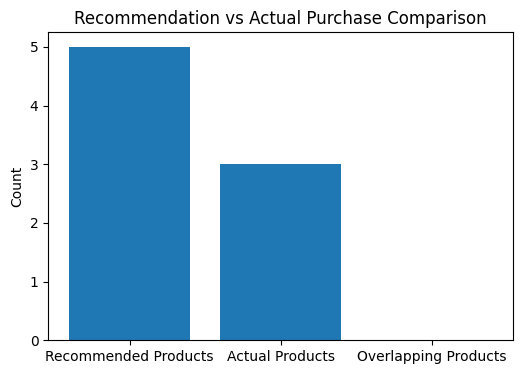

In [54]:
overlap_count = len(set(recommended).intersection(actual))

plt.figure(figsize=(6, 4))
plt.bar(
    ["Recommended Products", "Actual Products", "Overlapping Products"],
    [len(recommended), len(actual), overlap_count]
)

plt.ylabel("Count")
plt.title("Recommendation vs Actual Purchase Comparison")
plt.show()
